https://see.stanford.edu/materials/aimlcs229/cs229-notes3.pdf

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tqdm
import pdb
import time
import pdb
import timeit

In [134]:
def get_toy_svm_dataset_binary(num_samples=100, num_features=2, noise=0, w=None, b=None):
    X = (np.random.rand(num_samples, num_features) - 0.5) * 3
    if w is None:
      w = np.random.rand(num_features) - 0.5
    if b is None:
      b = np.random.rand(1) - 0.5
    y = ((X @ w) + b > 0).astype(int)
    y[y==0] = -1
    return X, y, w, b

In [135]:
# w and b in this case are optimal w and b
num_samples = 100
num_features = 2
X, y, w, b = get_toy_svm_dataset_binary(num_samples = num_samples, num_features=num_features)

In [136]:
def get_decision_boundary_points_2D(X, w, b):
    assert w.shape == (2,), "must have two weights"
    assert b.shape == (1,), "b must be scalar"
    assert X.shape[1] == 2, "X must have two features"

    x = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    y = (- ((x * w[0]) + b)) / w[1]
    return x, y

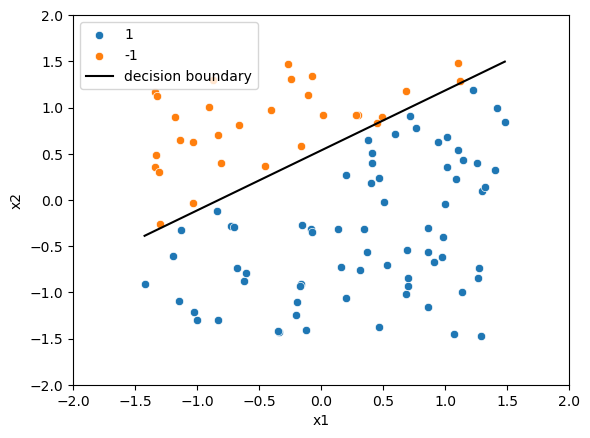

In [137]:
sns.scatterplot(x=X[y==1, 0], y=X[y==1, 1])
sns.scatterplot(x=X[y==-1, 0], y=X[y==-1, 1])
plt.plot(*get_decision_boundary_points_2D(X, w, b), c='black')

plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.xlabel('x1')
plt.ylabel('x2')

plt.legend(['1', '-1', 'decision boundary'])

In [138]:
def progress_bar(iterable, description):
    len_iterable = len(iterable)
    chunk = len_iterable // 100

    print(f'{description}:', end="")

    for idx, iter in enumerate(iterable):
        yield iter
        if idx % chunk == 0:
            print(f'-', end="")

In [139]:
def g(z):
    y_hat = z.astype(int)
    y_hat[y_hat==0] = -1
    return y_hat

# Functional Margin

In [140]:
def get_functional_margin(X, y, w, b):
    # if y = 1, need X@w+b to be large positive to get large positive output
    # opposite is true if y = -1
    # thus, a large positive functional margin tells us a sample is far away from the hyperplane and classified correctly
    # negative tells us that the classification is incorrect

    # gamma_hat --> all functional margins 
    gamma_hat = (y * (X @ w + b))
    return gamma_hat

In [141]:
def get_functional_margin_wrt_S(X, y, w, b):
    # S --> set of training examples
    gamma_hat = get_functional_margin(X, y, w, b)
    gamma_hat_wrt_S = np.min(gamma_hat) # the worst one
    return gamma_hat_wrt_S

In [142]:
# this is how its defined
gamma_hat_wrt_S = get_functional_margin_wrt_S(X, y, w, b)
gamma_hat_wrt_S
# this would correspond to a support vector

np.float64(0.0005226844879363812)

In [143]:
gamma_hat = get_functional_margin(X, y, w, b)
sample_with_min_functional_margin = X[gamma_hat == gamma_hat_wrt_S]

Text(0, 0.5, 'x2')

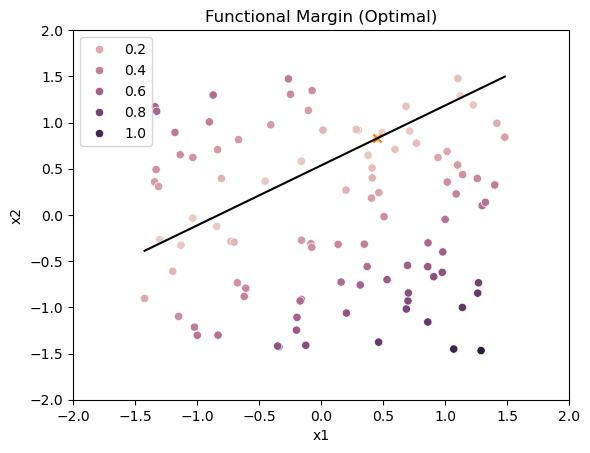

In [144]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue= get_functional_margin(X, y, w, b))
plt.scatter(sample_with_min_functional_margin[:, 0], sample_with_min_functional_margin[:, 1], marker='x')
plt.plot(*get_decision_boundary_points_2D(X, w, b), c='black')

plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.title('Functional Margin (Optimal)')
plt.xlabel('x1')
plt.ylabel('x2')

Text(0, 0.5, 'x2')

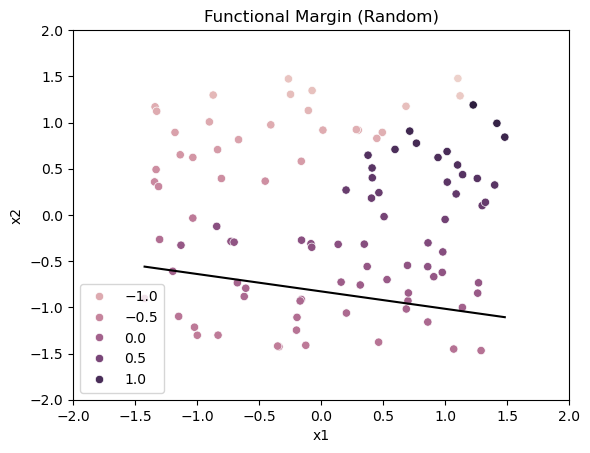

In [145]:
# demonstrating what functional margin looks like with bad decision boundary
random_w = np.random.rand(num_features)
random_b = np.random.rand(1)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue= get_functional_margin(X, y, random_w, random_b))
plt.plot(*get_decision_boundary_points_2D(X, random_w, random_b), c='black')

plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.title('Functional Margin (Random)')
plt.xlabel('x1')
plt.ylabel('x2')

Text(0, 0.5, 'x2')

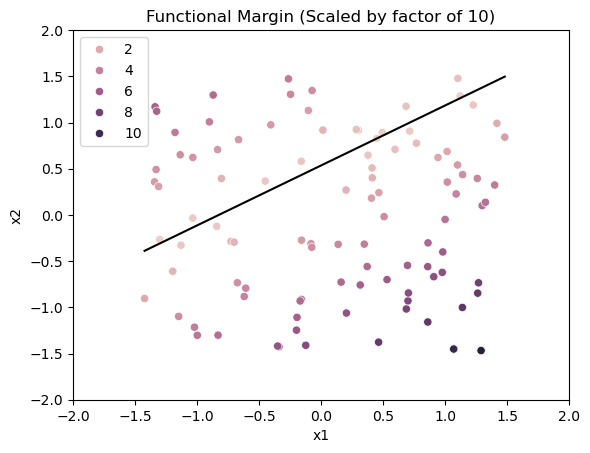

In [146]:
# demonstrating why functional margin is not great measure of confidence
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=get_functional_margin(X, y, 10*w, 10*b))
# we can arbitrarily scale w and b together and will scale functional marign as a result - see how it doubles

# could normalize it ... (this ends up being the geometric margin)

plt.plot(*get_decision_boundary_points_2D(X, w, b), c='black')

plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.title('Functional Margin (Scaled by factor of 10)')
plt.xlabel('x1')
plt.ylabel('x2')

# Geometric Margin

goal: find length of vector that is orthogonal to decision boundary and passes through sample. Aka perpendicular length to the decision boundary of each sample

In [147]:
def normalize_vector(v):
    # could use np.linalg.norm but that would break the rules :)
    norm = np.sqrt(np.sum(v**2))
    return v / norm

In [148]:
def get_geometric_margin(X, y, w, b):
    w_norm = np.sqrt(np.sum(w**2))

    # all geometric margins
    gamma = y * ((X @ (w / w_norm)) + (b / w_norm))

    return gamma

def get_geometric_margin_wrt_S(X, y, w, b):
    # S --> set of training examples
    gamma = get_geometric_margin(X, y, w, b)
    gamma_wrt_S = np.min(gamma) # the closest one; a support vector
    return gamma_wrt_S

Text(0.5, 1.0, 'Geometric Margin')

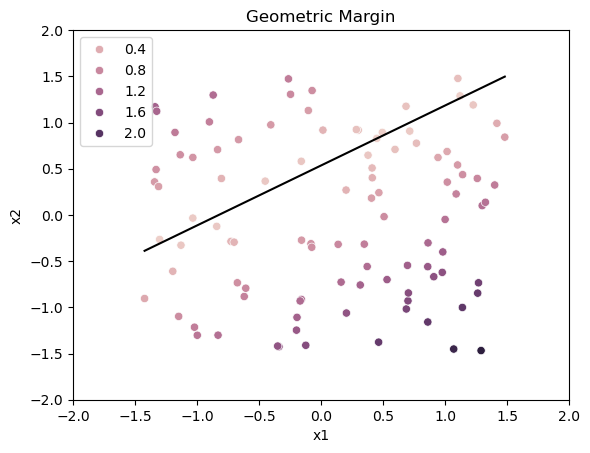

In [149]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=get_geometric_margin(X, y, w, b))
plt.plot(*get_decision_boundary_points_2D(X, w, b), c='black')

plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.xlabel('x1')
plt.ylabel('x2')

plt.title('Geometric Margin')

This is literally just a normalized functional margin. Also, if the norm of the weight vector is 1, they are the same

# Kernels

In [150]:
def get_kernel(x1, x2, kernel_type = 'linear'):
    # phi = feature mapping
    if kernel_type == 'linear':
        phi = lambda x: x
        return np.dot(phi(x1), phi(x2))

    if kernel_type == 'gaussian':
        raise NotImplementedError()

    raise ValueError(f'Kernel {kernel_type} not supported')

In [151]:
def get_kernel_matrix(X, kernel_type = 'linear'):
    # this could probably be vectorized
    num_samples = X.shape[0]
    kernel_matrix = np.zeros(shape=(num_samples, num_samples))
    for i in range(num_samples):
        x1 = X[i]
        for j in range(num_samples):
            x2 = X[j]
            K_i_j = get_kernel(x1, x2, kernel_type)
            kernel_matrix[i, j] = K_i_j
    return kernel_matrix

In [152]:
K = get_kernel_matrix(X, kernel_type='linear')

In [153]:
K.shape

(100, 100)

In [154]:
# same vectors point in same direction, have higher dot products
np.diag(K).mean(), K.mean()

(np.float64(1.4500501302516478), np.float64(0.01223911464058459))

In [155]:
def validate_kernel_matrix(K):
    # really should also validate positive semi-definiteness (mercer theorem)
    assert K.shape[0] == K.shape[1], "K is not a valid kernel matrix; must be square"
    num_samples = K.shape[0]
    for i in range(num_samples):
        for j in range(num_samples):
            if i != j:
                # basically we're confirming that the kernel function is commutative (order of i, j vs j, i is irrelevant)
                assert K[i, j] == K[j, i], "K is not a valid kernel matrix; must be symmetric"


In [156]:
validate_kernel_matrix(K)

# Lagrange Multiplier Initialization

In [157]:
def get_initial_alpha(num_samples, y):
    # "alpha" = vector filled with lagrange multipliers
    # generate random alphas for negative samples
    alpha = np.zeros_like(y, dtype=float)
    num_negative = np.sum(y==-1)
    alpha[y == -1] = np.random.rand(num_negative) * 0.01

    # get dot product to compute scaling factor for positive samples
    initial_dot = alpha @ y

    # count positive samples
    num_positive = np.sum(y == 1)

    # initial random alphas for positive samples
    random_alpha_for_positive_samples = np.random.rand(num_positive)

    # normalize so they sum to 1
    norm_alpha_for_positive_samples = random_alpha_for_positive_samples / np.sum(random_alpha_for_positive_samples)
    assert np.isclose(np.sum(norm_alpha_for_positive_samples), 1), 'normalization of initial lagrange multipliers for positive samples failed: sum != 1'

    # scale with initial dot computed before
    scaled_alpha_for_positive_samples = -(norm_alpha_for_positive_samples * initial_dot)
    assert np.isclose(-np.sum(scaled_alpha_for_positive_samples), initial_dot), 'scaling of initial lagrange multipliers for positive samples failed: -sum != initial dot'

    # sub in alphas for positive samples
    alpha[y==1] = scaled_alpha_for_positive_samples

    # does this satisfy sum(alpha_i * y_i for all i) = 0 constraint?
    assert np.isclose(alpha @ y, 0), 'failed to generate random lagrange multipliers: alpha @ y != 0 '

    return alpha

def alpha_to_w(alpha, X, y):
    # express w in terms of lagrange mutlipliers (alphas), X, and y
    w = np.sum((alpha * y).reshape(-1, 1) * X, axis=0)

    # equivalent to: np.sum([alpha[i] * y[i] * X[i] for i in range(len(alpha))], axis=0)

    assert w.shape[0] == X.shape[1], f'mismatch between number of weights produced {w.shape[0]} and number of features {X.shape[1]}'

    return w

In [158]:
alpha = get_initial_alpha(num_samples, y)
w = alpha_to_w(alpha, X, y)

In [159]:
b = 0 # have to compute later based on the support vectors somehow
C = 10 # totally arbitrary, can and should test other values
# https://medium.com/@pushkarmandot/what-is-the-significance-of-c-value-in-support-vector-machine-28224e852c5a

# SMO

In [160]:
get_geometric_margin_wrt_S(X, y, w, b)

np.float64(-0.3771990292947105)

In [161]:
# objective function: maximize
def W_slow(alpha, K, y):
    first_part = np.sum(alpha)

    second_part = 0

    for i in range(len(alpha)):
        for j in range(len(alpha)):
              second_part += y[i] * y[j] * alpha[i] * alpha[j] * K[i, j]

    W_alpha = first_part - (0.5 * second_part)

    return W_alpha

In [162]:
W_alpha = W_slow(alpha, K, y)
W_alpha

np.float64(0.2840331970576611)

In [163]:
timeit.timeit(lambda: W_slow(alpha, K, y), number=10)

0.04548412491567433

In [164]:
def is_greater_or_close(a, b, rtol=1e-5, atol=1e-8):
    return np.logical_or(a > b, np.isclose(a, b, rtol=rtol, atol=atol))

def is_less_or_close(a, b, rtol=1e-5, atol=1e-8):
    return np.logical_or(a < b, np.isclose(a, b, rtol=rtol, atol=atol))

In [165]:
def check_KKT(X, y, alpha, c, w, b, tol=0.01):
    # karush-kuhn-tucker conditions. tests for convergence
    # 'tol' here is absolute tolerance. Could also use relative tolerance
    # Ng : "Here, tol is the convergence tolerance parameter, and is typically set to around 0.01 to 0.001"
    warnings.warn('this function has not been tested at all')

    kkt_results = {}
    gamma_hat = get_functional_margin(X, y, w, b) # use geometric margin? idk work this out

    # αi = 0 ⇒ yi(xi @ w + b) >= 1
    condition_1_bool = is_greater_or_close(gamma_hat[alpha == 0], 1, rtol=0, atol=tol)
    condition_1_passed = np.all(condition_1_bool)
    kkt_results['condition_1'] = condition_1_passed

    # αi = C ⇒ yi(xi @ w + b) <= 1
    condition_2_bool = is_less_or_close(gamma_hat[alpha == c], 1, rtol=0, atol=tol)
    condition_2_passed = np.all(condition_2_bool)
    kkt_results['condition_2'] = condition_2_passed

    # 0 < αi < C ⇒ yi(xi @ w + b) = 1
    condition_3_bool = np.isclose(gamma_hat[(alpha > 0) & (alpha < c)], rtol=0, atol=tol)
    condition_3_passed = np.all(condition_3_bool)
    kkt_results['condition_3'] = condition_3_passed

    return kkt_results

In [166]:
# naive SMO - no heuristic in selecting alpha_i, alpha_j
i, j = np.random.choice(range(len(alpha)), size=2, replace=False)

alpha_i = alpha[i]
alpha_j = alpha[j]

assert alpha_i in alpha, "alpha_i not in alpha"
assert alpha_j in alpha, "alpha_j not in alpha"

In [167]:
y_i = y[i]
y_j = y[j]

In [168]:
# exclude i and j. Why is this method called delete? Not an inplace operation
zeta = -((np.delete(alpha, [i, j]) @ np.delete(y, [i, j])))

assert np.isclose(-zeta + (alpha_i*y_i) + (alpha_j*y_j), alpha @ y), "zeta not computed correctly" # this should really also include == 0, but alpha is random for now

zeta

np.float64(0.0018938557395975662)

In [169]:
# would need to check this at every optimization step to make sure not fucking up your alphas
# assert np.isclose(alpha @ y, 0), "sum of y values multiplied with lagrange multipliers must be 0"

In [170]:
alpha @ y

np.float64(-3.903127820947816e-18)